# Stage 2
## CNN + Masks (UNET)

Bacterial vs. viral lung

This notebook uses the model from 
https://ieeexplore.ieee.org/abstract/document/9057809

In addition we add segmentation masks from unet to a 2. channel of the images.
The input is therefore CXR + Cutout (grayscale img).

In [1]:
import pandas as pd
import math
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, Conv2D, MaxPool2D, Activation, GlobalAveragePooling2D, Conv2DTranspose
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
# Config
IMG_SIZE = 256
BATCH_SIZE=32
train_path = 'data/chest-x-ray/train/'
test_path = 'data/chest-x-ray/test/'
val_path = 'data/chest-x-ray/val/'

train_mask_path = 'data/chest-x-ray/masks/aaa/train/'
val_mask_path = 'data/chest-x-ray/masks/aaa/val/'
test_mask_path = 'data/chest-x-ray/masks/aaa/test/'

# covid19
coivd_path = 'data/chest-x-ray/covid19_2/img'
covid_mask_path = 'data/chest-x-ray/covid19_2/masks'

In [3]:
np.random.seed(200)
tf.random.set_seed(200)

## 1 Data preparation

In [4]:
def load_images_from_folder(img_folder, masks_folder):
    tmp_df = pd.DataFrame(columns = ['img', 'label', 'mask']) 
    # IMGs
    for label_folder in os.listdir(img_folder):
        for filename in os.listdir(img_folder + '/' + label_folder):
            img_path = str(img_folder)+str(label_folder)+'/'+str(filename)
            # normal file ending is jpEg...
            filename_wo_ending = filename.split('.jpeg')[0]
            mask_path = str(masks_folder)+str(label_folder)+'/'+str(filename_wo_ending) + '_predmask.jpg'
            label2 = '-'
            if img_path is not None:
                if label_folder != 'NORMAL':
                    label2 = filename_wo_ending.split("_")[1].split("_")[0]

                tmp_df = tmp_df.append({'img': img_path, 'mask': mask_path, 'label': label_folder, 'label2': label2, 'label3': '-'}, ignore_index=True)

    return tmp_df

In [5]:
def load_covid_images_from_folder(img_folder, masks_folder):
    tmp_df = pd.DataFrame(columns = ['img', 'label', 'mask']) 
    for filename in os.listdir(img_folder):
        img_path = str(img_folder)+'/'+str(filename)
        label = 'PNEUMONIA' # virurs => covid19
        # normal file ending is jpEg...
        filename_wo_ending = filename.rsplit('.')[0]
        mask_path = str(masks_folder)+'/'+str(filename_wo_ending) + '_predmask.jpg'
        if img_path is not None:
            tmp_df = tmp_df.append({'img': img_path,  'mask': mask_path, 'label': label, 'label2': 'virus', 'label3': 'covid19'}, ignore_index=True)

    return tmp_df

In [6]:
df_train = load_images_from_folder(train_path, train_mask_path)
df_val = load_images_from_folder(val_path, val_mask_path)
df_test = load_images_from_folder(test_path, test_mask_path)
df_covid = load_covid_images_from_folder(coivd_path, covid_mask_path)

In [7]:
# Split covid19 data
from sklearn.model_selection import train_test_split
df_train_covid, df_test_covid = train_test_split(df_covid, test_size=0.2, random_state=200)
df_train_covid, df_val_covid = train_test_split(df_train_covid, test_size=0.05, random_state=200)

In [8]:
print('=== Covid Data: ===')
print('Train:', len(df_train_covid))
print('Val:', len(df_val_covid))
print('Test:', len(df_test_covid))

=== Covid Data: ===
Train: 155
Val: 9
Test: 42


In [9]:
df_train = df_train[df_train.label != 'NORMAL']
df_test = df_test[df_test.label != 'NORMAL']
df_val = df_val[df_val.label != 'NORMAL']

In [10]:
# Append Covid19 data to rest
df_train = df_train.append(df_train_covid, ignore_index=True)
df_val = df_val.append(df_val_covid, ignore_index=True)
df_test = df_test.append(df_test_covid, ignore_index=True)

In [11]:
print('=== Train Data: ===')
print('Pneumonia:', len(df_train[df_train['label'] == 'PNEUMONIA']))
print('|---> Bacterial:', len(df_train[df_train['label2'] == 'bacteria']))
print('|---> Viral:', len(df_train[df_train['label2'] == 'virus']))
print('    |---> Covid:', len(df_train[df_train['label3'] == 'covid19']))

=== Train Data: ===
Pneumonia: 4030
|---> Bacterial: 2530
|---> Viral: 1500
    |---> Covid: 155


In [12]:
print('=== Test Data: ===')
print('Pneumonia:', len(df_test[df_test['label'] == 'PNEUMONIA']))
print('|---> Bacterial:', len(df_test[df_test['label2'] == 'bacteria']))
print('|---> Viral:', len(df_test[df_test['label2'] == 'virus']))
print('    |---> Covid:', len(df_test[df_test['label3'] == 'covid19']))

=== Test Data: ===
Pneumonia: 408
|---> Bacterial: 234
|---> Viral: 174
    |---> Covid: 42


In [13]:
print('=== Val Data: ===')
print('Pneumonia:', len(df_val[df_val['label'] == 'PNEUMONIA']))
print('|---> Bacterial:', len(df_val[df_val['label2'] == 'bacteria']))
print('|---> Viral:', len(df_val[df_val['label2'] == 'virus']))
print('    |---> Covid:', len(df_val[df_val['label3'] == 'covid19']))

=== Val Data: ===
Pneumonia: 41
|---> Bacterial: 16
|---> Viral: 25
    |---> Covid: 9


In [14]:
# Shuffle
df_train = df_train.sample(frac=1, random_state=200).reset_index(drop=True)
df_val = df_val.sample(frac=1, random_state=200).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=200).reset_index(drop=True)

In [15]:
def replace_by_binary_class(df, to_replace, value):
    return df.replace(to_replace=to_replace, value=value)

In [16]:
df_train = replace_by_binary_class(df_train, 'bacteria', 0)
df_train = replace_by_binary_class(df_train, 'virus', 1)

df_val = replace_by_binary_class(df_val, 'bacteria', 0)
df_val = replace_by_binary_class(df_val, 'virus', 1)

df_test = replace_by_binary_class(df_test, 'bacteria', 0)
df_test = replace_by_binary_class(df_test, 'virus', 1)

In [17]:
df_train.tail()

,img,label,mask,label2,label3
4025,data/chest-x-ray/train/PNEUMONIA/person536_vir...,PNEUMONIA,data/chest-x-ray/masks/aaa/train/PNEUMONIA/per...,1,-
4026,data/chest-x-ray/train/PNEUMONIA/person293_vir...,PNEUMONIA,data/chest-x-ray/masks/aaa/train/PNEUMONIA/per...,1,-
4027,data/chest-x-ray/train/PNEUMONIA/person1375_ba...,PNEUMONIA,data/chest-x-ray/masks/aaa/train/PNEUMONIA/per...,0,-
4028,data/chest-x-ray/train/PNEUMONIA/person1312_ba...,PNEUMONIA,data/chest-x-ray/masks/aaa/train/PNEUMONIA/per...,0,-
4029,data/chest-x-ray/train/PNEUMONIA/person280_bac...,PNEUMONIA,data/chest-x-ray/masks/aaa/train/PNEUMONIA/per...,0,-



## 2 Data generator

In [18]:
import imgaug as ia
import imgaug.augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
sometimes25 = lambda aug: iaa.Sometimes(0.25, aug)

seq_img = iaa.Sequential([
    # sometimes(iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6))),
    sometimes(iaa.Affine(
            rotate=(-10, 10),
            shear=(-10,10),
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}
    )),
    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
], random_order=True)

class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, augment, img_size, batch_size=8, shuffle=True, useMasks=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.augment = augment
        self.img_size = img_size
        self.useMasks = useMasks

    def __len__(self):
        return math.ceil(len(self.indices)/ self.batch_size)

    def __getitem__(self, index):
        indexes = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in indexes]
        X, y = self.__get_data(batch)
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __get_data(self, batch):
        X_img_paths = self.df['img']
        X_mask_paths = self.df['mask']
        X_imgs = []
        X_masks = []
        Y = self.df['label2'].iloc[batch].to_numpy()

        for i in range(0, len(batch)):
            img = cv2.resize(cv2.imread(str(X_img_paths.iloc[batch[i]]), CV2.IMREAD_GRAYSCALE), (self.img_size, self.img_size))
            img = img.reshape(self.img_size, self.img_size, 1)
            if not self.useMasks:
                if(self.augment is True):
                    seq_img_i = seq_img.to_deterministic()   
                    img = seq_img_i.augment_image(img)
                # else img remains untouched
            else: 
                img_grayscaled = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                mask = cv2.imread(str(X_mask_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (self.img_size, self.img_size))
                mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)[1]
                mask = mask.reshape(self.img_size, self.img_size, 1)

                # Multiply binarized mask on grayscaled version of the x-ray. 
                # So only the lung will remain, everything else will be set to 0
                cutout_img = img_grayscaled * mask

                if(self.augment is True):
                    seq_img_i = seq_img.to_deterministic()   
                    img = seq_img_i.augment_image(img) #### img
                    cutout_img = seq_img_i.augment_image(cutout_img) #### cutout

                img = np.dstack([img, cutout_img])

            # normalize
            img = img / 255.0

            X_imgs.append(img)

        return X_imgs, Y

In [20]:
train_generator = DataGenerator(df_train, True, IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True, useMasks=False)
val_generator = DataGenerator(df_val, False, IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False, useMasks=False)

In [21]:
a = train_generator.__getitem__(1)[0][0]

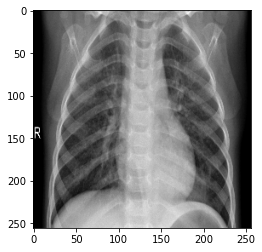

In [22]:
plt.imshow(a[:,:,0], cmap='gray')

In [23]:
plt.imshow(a[:,:,1], cmap='gray')

IndexError: index 3 is out of bounds for axis 2 with size 3

## 3 Model training

In [24]:
# We can use sklearn for this - see next cell

# weight_for_0 = (1 / len(df_train.loc[df_train['label'] == 0]))*(len(df_train))/2.0 
# weight_for_1 = (1 / len(df_train.loc[df_train['label'] == 1]))*(len(df_train))/2.0
# class_weights = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [31]:
model = Sequential()
# Conv block1 = cb0
model.add(Conv2D(32, (3,3), padding = "same", activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3), name="cb0_conv0"))
model.add(Conv2D(32, (3,3), padding = "same", activation='relu', name="cb0_conv1"))
model.add(MaxPool2D(pool_size = (3, 3), name="cb0_maxpool"))
model.add(Dropout(0.2, name="cb0_dropout"))

# Conv block2 = cb1
model.add(Conv2D(64, (3,3), padding = "same", activation='relu', name="cb1_conv0"))
model.add(Conv2D(64, (5,5), strides=(2,2), padding = "same", activation='relu', name="cb1_conv1"))
model.add(Conv2D(64, (3,3), padding = "same", activation='relu', name="cb1_conv2"))
model.add(MaxPool2D(pool_size = (2, 2), name="cb1_maxpool"))
model.add(Dropout(0.2, name="cb1_dropout"))

# Dense block = db
model.add(Flatten())
model.add(Dense(1024, activation='relu', name="db_dense1024"))
model.add(Dense(512, activation='relu', name="db_dense512"))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', name="db_dense256"))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid', name="db_dense1"))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [32]:
# Adjust class_weights since we're dealing with imbalanced data here
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df_train['label2']),
                                                 df_train['label2'])
class_weights = {0: class_weights[0], 1: class_weights[1]}

In [33]:
class_weights

{0: 0.7964426877470355, 1: 1.3433333333333333}

In [34]:
mcp_save = ModelCheckpoint('models/custom_bacteria_vs_viral_0809_wo_masks.h5', save_best_only=True, monitor='val_accuracy', mode='max')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 1, verbose=1,factor=0.1, min_lr=0.000001, min_delta=0.01)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0, 
                              patience=0,
                              verbose=0, mode='min')

In [35]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    steps_per_epoch=len(train_generator),
                    epochs=12,
                    class_weight=class_weights,
                    callbacks=[mcp_save , learning_rate_reduction],
                    verbose = True)

Epoch 1/12
126/126 [==============================] - 47s 376ms/step - loss: 0.6949 - accuracy: 0.4965 - val_loss: 0.6941 - val_accuracy: 0.4146
Epoch 2/12
126/126 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.4898
Epoch 00002: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
126/126 [==============================] - 47s 371ms/step - loss: 0.6909 - accuracy: 0.4898 - val_loss: 0.6913 - val_accuracy: 0.4878
Epoch 3/12
126/126 [==============================] - ETA: 0s - loss: 0.6749 - accuracy: 0.5648
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-06.
126/126 [==============================] - 47s 375ms/step - loss: 0.6749 - accuracy: 0.5648 - val_loss: 0.6889 - val_accuracy: 0.5854
Epoch 4/12
126/126 [==============================] - 46s 364ms/step - loss: 0.6673 - accuracy: 0.5618 - val_loss: 0.6928 - val_accuracy: 0.4878
Epoch 5/12
126/126 [==============================] - 46s 363ms/step - loss: 0.6663 - accuracy: 0.6005 - v

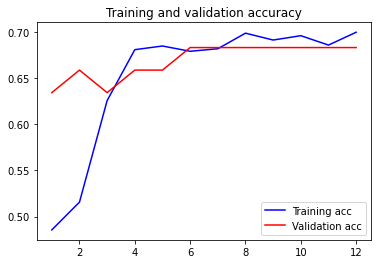

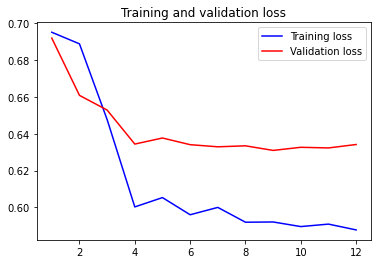

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 4 Model evaluation

In [56]:
model = tf.keras.models.load_model("models/custom_bacteria_vs_viral_0809.h5", compile=True)

In [57]:
len(df_test[df_test.label2 == 1])

174

In [63]:
test_generator = DataGenerator(df_test, False, IMG_SIZE, batch_size=32, shuffle=False, useMasks=True)

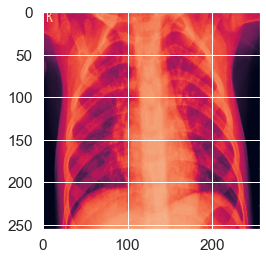

In [64]:
plt.imshow(test_generator.__getitem__(0)[0][0][:,:,0])

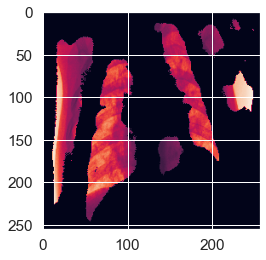

In [65]:
plt.imshow(test_generator.__getitem__(0)[0][0][:,:,3])

In [66]:
model.evaluate(test_generator)

13/13 [==============================] - 4s 309ms/step - loss: 0.3645 - accuracy: 0.8799


[0.36449652910232544, 0.8799019455909729]

## Detail eval

In [67]:
predictions = model.predict(test_generator)

In [68]:
y_true = test_generator.df.label2 # we can do this since we do not shuffle in test_generator ;)
y_pred = predictions > 0.5

In [69]:
y_pred_classes = []

for x in y_pred:
    if x == 0:
        y_pred_classes.append("bacteria")
    else:
        y_pred_classes.append("viral")

In [70]:
y_true_classes = []

for x in y_true:
    if x == 0:
        y_true_classes.append("bacteria")
    else:
        y_true_classes.append("viral")

In [71]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[204  30]
 [ 19 155]]


In [72]:
report = classification_report(y_true_classes, y_pred_classes) #, target_names=["NORMAL", "PNEUMONIA"])
print(report)

precision    recall  f1-score   support

    bacteria       0.91      0.87      0.89       234
       viral       0.84      0.89      0.86       174

    accuracy                           0.88       408
   macro avg       0.88      0.88      0.88       408
weighted avg       0.88      0.88      0.88       408



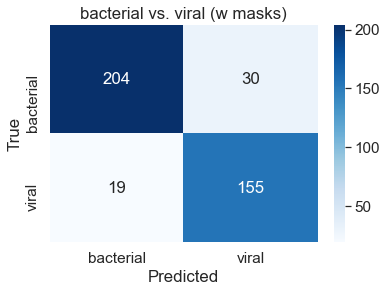

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells
sns.set(font_scale=1.4)

# labels, title and ticks
ax.set_xlabel('Predicted');
ax.set_ylabel('True'); 
ax.set_title('bacterial vs. viral (w masks)'); 
ax.xaxis.set_ticklabels(['bacterial', 'viral']); ax.yaxis.set_ticklabels(['bacterial', 'viral']);